In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from keras import Model
from keras.saving import load_model

model: Model = load_model('../model/bin/model.keras')

with open('../data/processed/bin/sequences/test/X_test.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('../data/processed/bin/sequences/test/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)

2024-03-22 10:57:58.992346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model.summary()

Model: "index-price-prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6, 13)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 6, 4)           │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 34)             │         5,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            35 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,883 (65.95 KB)

 Trainable params: 5,627 (21.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,256 (43.97 KB)

In [4]:
data = pd.read_csv('../data/processed/csv/input.csv')

In [5]:
data = data.tail(len(y_test)+1)
data.reset_index(drop=True,inplace=True)

In [6]:
def log_returns_to_price(log_returns: np.ndarray, first: float) -> pd.Series:
    l = len(log_returns)
    prices = np.empty(l+1,dtype = np.float32)
    prices[0] = first
    for i in range(1,l+1):
        prices[i] = np.exp(log_returns[i-1]) * prices[i-1]
    
    prices = pd.Series(prices)
    prices = prices.tail(l)
    return prices

In [7]:
def mean_absolute_percentage_error(actual: pd.Series, predicted: pd.Series) -> np.float32:
    return ((actual - predicted)/actual).abs().mean()
def mean_absolute_error(actual: pd.Series, predicted: pd.Series) -> np.float32:
    return ((actual - predicted)).abs().mean()
def root_mean_squared_error(actual: pd.Series, predicted: pd.Series) -> np.float32:
    return np.sqrt((actual - predicted).pow(2).mean())

In [8]:
first = data.loc[0, 'Adj Close']
data = data.tail(len(y_test))

In [9]:
prediction = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


In [10]:

prediction = prediction.reshape(-1)

In [11]:
data['Predicted Close'] = log_returns_to_price(prediction, first)
data.set_index('Date', inplace=True)

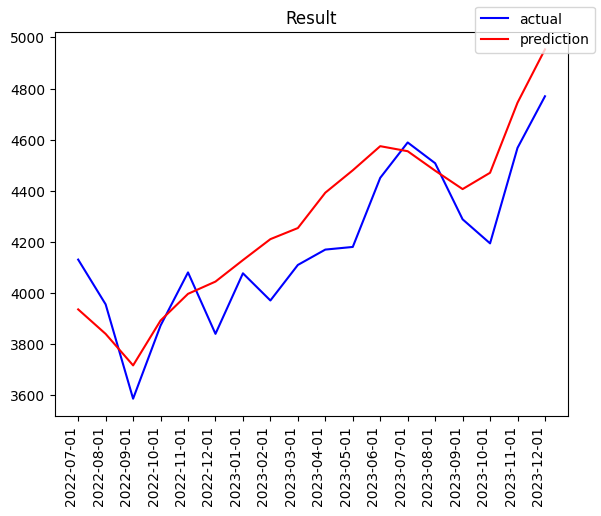

In [18]:
fig, ax  = plt.subplots()
ax.plot(data['Adj Close'], color = 'blue', label = 'actual')
ax.plot(data['Predicted Close'], color = 'red', label = 'prediction')
fig.tight_layout()
fig.legend()
fig.set_figwidth(6)
fig.set_figheight(5)
fig.autofmt_xdate(rotation=90)
ax.set_title('Result')
fig.savefig('../model/vis/result.png')

In [ ]:
MAPE = mean_absolute_percentage_error(data['Adj Close'], data['Predicted Close'])
MAPE

0.03544160145521935

In [ ]:
MAE = mean_absolute_error(data['Adj Close'], data['Predicted Close'])
MAE

147.3097601536459

In [ ]:
RMSE = root_mean_squared_error(data['Adj Close'], data['Predicted Close'])
RMSE

168.58417348343644

In [ ]:
spearman_correlation = data[['Adj Close']].corrwith(data['Predicted Close'], method='spearman').values[0]
spearman_correlation

0.9112487100103198

In [ ]:
result = {'Mean Absolute Percentage Error': MAPE, 'Mean Absolute Error':MAE, 'Root Mean Squared Error': RMSE, 'Spearman Coefficient': spearman_correlation }
pd.DataFrame(result, index=[0]).to_csv('../model/results/metrics.csv', index=False)